In [10]:
# %pip install rusenttokenize
# %pip install tokenizers

# GPT

В этом семинаре мы поговорим про GPT - одну из самых распространенных архитектур больших языковых моделей. Прежде всего GPT ассициируется с моделями от OpenAI, но большинство топовых языковых моделей так или иначе основаны или вдохновлены GPT, даже если называются они по-другому.

Давайте кратко пройдемся по эволюции GPT и отметим как с развитием модели трансформировалась и сама дисциплина NLP.

### GPT-1 Improving Language Understanding by Generative Pre-Training


GPT-1 [вышла](https://cdn.openai.com/research-covers/language-unsupervised/language_understanding_paper.pdf) в 2018 году незадолго до BERT. В целом она не предлагала чего-то революционно нового и укладывалась уже в существующих подход - предобучение на языковом моделировании + дообучение под конкретную задачу. Сам подход очень похож на ULMFit, но в GPT использовался трансформер. Архитектура модели была аналогична Attention is all you need за исключением того, что тут использовался просто decoder-only подход. Модель предобучалась на корпусе книг BookCorpus и авторы подчеркивают, что это дало им важное преимущество перед ELMo, которая обучалась на большем корпусе, но поделенном на предложения. Для дообучения использовался подход схожий с ULMFit, где поверх предобученой модели добавлялся еще один классификационный слой. Однако в GPT-1 они также придумали как подстроить другие типы задач, не перестраивая саму модель - для простой классификации использовалось просто последнее состояние выдаваемое моделью, а для задач вроде sentence similarity, question answering, entailment они превращали данные в одну последовательность по шаблону, используя какие-то разделители. Для entailment также использовалось только последнее состояние, а вот для similarity они брали два вектора (они делали split по разделителю и брали последние вектора в двух списках). Для задачи question answering они объединяли все комбинации текст-вопрос-ответ в последовательности и брали софтмакс поверх вариантов ответов. 
Размер GPT-1 - 113 миллионов параметров.

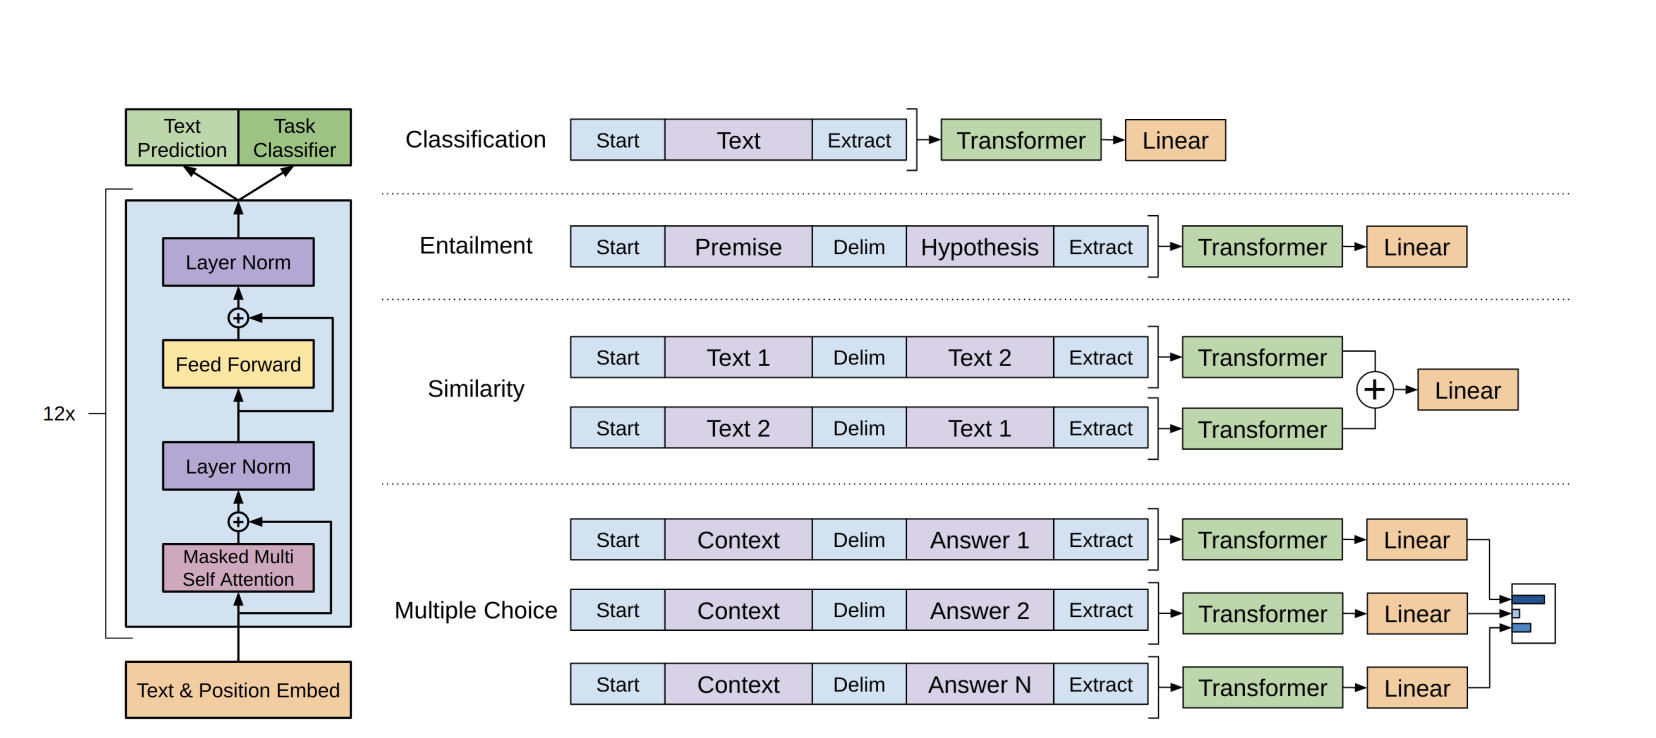



### GPT-2 Language Models are Unsupervised Multitask Learners
GPT-2 [вышла](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf) в 2019 году. Архитектура практически не изменилась, главное отличие было в масштабе - самая большая версия уже имела 1.5 миллиарда параметров и была обучена на 40гб текста. Корпус для обучения расширили за счет интернет статей, но для того, чтобы собрать качественные данные использовались эвристики вроде сбора ссылок на reddit c upvotes. Но простое изменение масштаба оказалось куда влиятельнее, чем может изначально показаться. Сама парадигма - предобучение->дообучение стала меняться. В GPT-2 было показано, что при достаточно большом размере и количестве данных, модель можешь выучить многие задачи на этапе предобучения и дальнешего добучения может и не понадобится! Достаточно найти такой паттерн, который даст модели сигнал, что нужно решить конкретную задачу (например, для перевода можно подставить в конец текста что-то вроде "{text} translates to Russian as: "). Разумеется качество предсказаний обычно не превосходит таргетированные модели с дообучением, но то, что модель можно решать большой набор задач из коробки (zero shot) уже удивительно.  С GPT-2 появился prompt engineering и в то время он заключался в поиске таких патернов, которые наилучшим способом сообщают модели целевую задачу. 
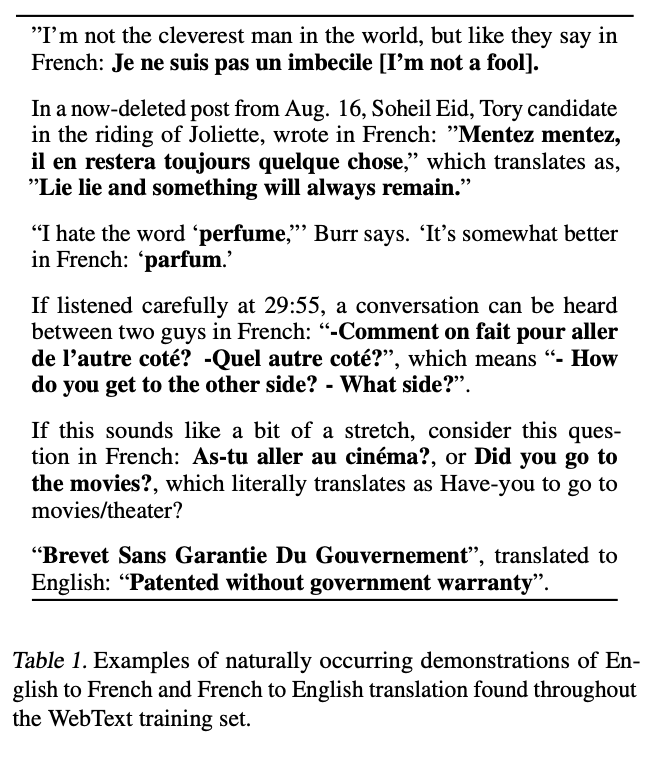

Еще можно упомянуть, что уже при релизе GPT-2, OpenAI серьезно задумались о безопасности выпуска такой модели в открытый доступ. Сам релиз был разделен на несколько этапов, где сначала была выложена только самая маленькая модель, а затем каждые несколько месяцев выпускалась следующая версия, чтобы дать время миру на адаптацию и иметь возможность вовремя остановиться и предотвратить еще больший ущерб. Никаких серьзных последствий у релиза GPT-2 не было, но такой "осторожный" подход к релизам сохранился и даже усилился в следующей версии.




### GPT-3 Language Models are Few-Shot Learners
В 2020 OpenAI [выпустила](https://arxiv.org/abs/2005.14165) GPT-3. Самая большая версия модели теперь была 175 миллиардов параметров, что и по текущим меркам огромное количество параметров. За счет увеличения размера модели и количества данных, стало еще нагляднее, что модель способна обучаться огромному количеству задач просто на задаче языкового моделирования. Помимо специальных промтов триггеров еще обнаружилось, что модель может понять задачу просто из контекста (in context learning) - если показать ей несколько примеров, то дальше она будет предсказывать по аналогии. Таким образом дообучение все еще не требуется, но часть обучающих данных можно все равно использовать в качестве примеров (few shot вместо zero shot) и это значительно улучшает качество. 
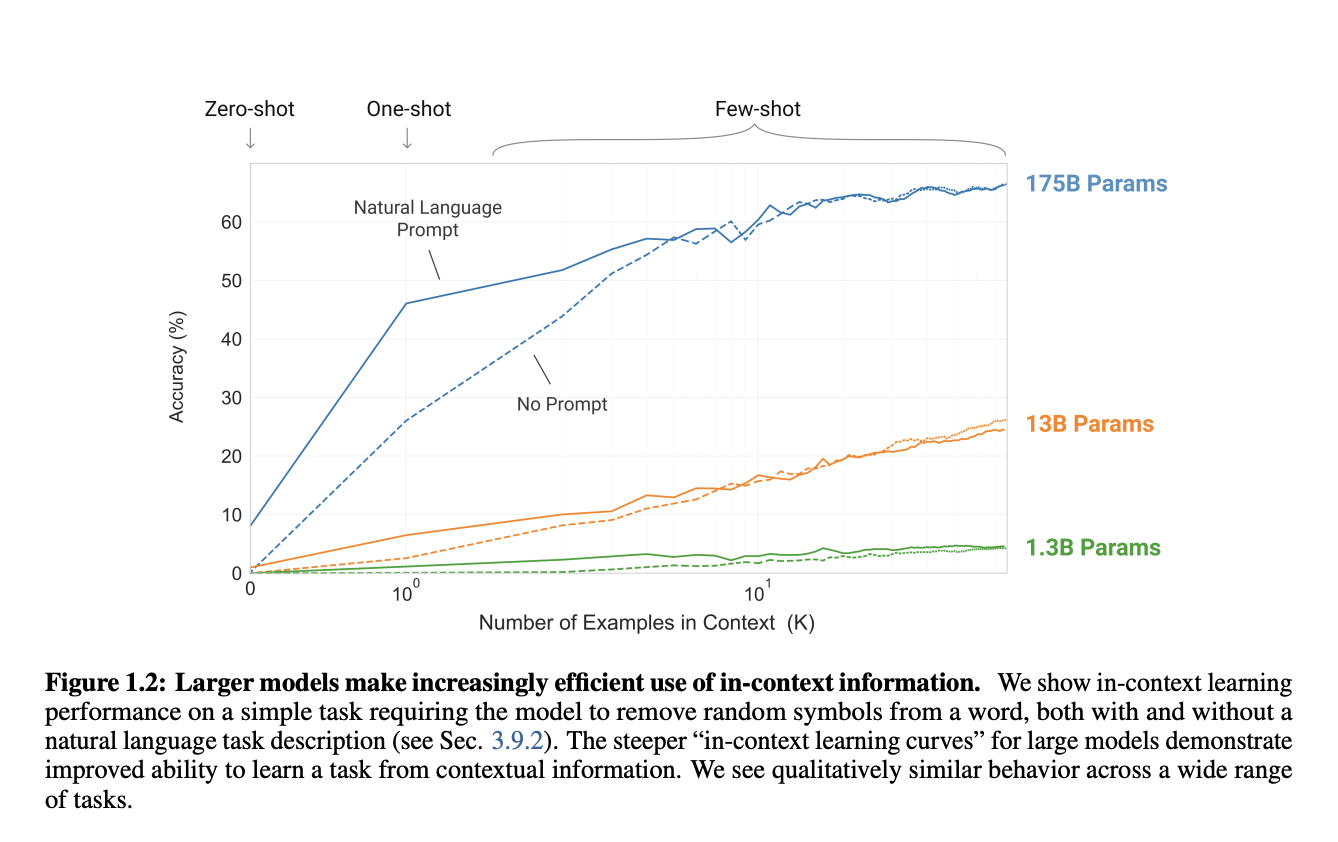

За счет того, что размер модели такой большой, OpenAI даже не стали выкладывать ее целиком - все равно у большинства пользователей не будет ресурсов, чтобы ее эффективно запустить. Поэтому GPT-3 предоставлялась только через API. 


### gpt 3.5 instruct
Последняя хоть сколько-то открытая работа в ряду GPT моделей - это gpt 3.5 instruct ([статья](https://arxiv.org/pdf/2203.02155))
GPT-1,2,3 последовательно фокусировались на предобучении, показывая что многие проблемы, которые ранее требовали дообучения, могут решаться за счет увеличения машстаба и датасетов. Дообучение все еще очень эффективно и нужно для улучшения модели на новые задачи, но оно часто ведет к тому, что модель теряет универсальность полученную на этапе предобучения. Многие статьи того времени пытались найти более эффективный подход к дообучению, который бы позволил сохранять универсальность. И в итоге все сошлось к тому, что дообучать модель можно не на отдельных конкретных целевых задачах, а более абстрактной задаче следования инструкциям, под которую можно подстроить практически все реальные задачи. Модель дообученная на иструкциях к тому же гораздно удобнее на практике - ей не нужно подбирать какой-то паттерн триггер, а можно просто сформировать запрос в виде инструкции. Задача при этом все еще сводится к языковому моделированию, но на этапе дообучения модель учится предсказывать ответы на инструкции, а не просто сырой текст. 
Важная часть gpt 3.5 instruct это еще Reinforcement learning, который решал другое ограничения supervised дообучения - разреженность сигнала. Но про это мы еще поговорим отдельно. 

GPT-3.5 почти сразу же превратилась в ChatGPT и стала коммерческим продуктом. С тех пор OpenAI не публикует статьи по своим новым моделям. Они все еще называются GPT-4, GPT-5.3 но на самом деле это уже больше бренд чем архитектура, вполне возможно что последние модели это уже не просто авторегрессивные трансформеры, а что-то более сложное.

### Обучение GPT модели с нуля
В этом семинаре мы попробуем натренировать простую версию GPT. Код в очень большой части основан на вот этом туториале от Andrej Karpathy - https://www.youtube.com/watch?v=kCc8FmEb1nY . Я добавил более объемный датасет, BPE токенизацию, а также некоторые дополнительные пояснения, но основной код практически точно такой же, потому что сложно придумать что-то лучше.

Помимо собственно разбора GPT модели, в этом семинаре также разбирается pytorch. 
Но прежде чем переходить к этому, давайте загрузим данные.

## Данные и токенизация

Для обучения GPT нужен текст. Чем больше, тем лучше. В туториале использовался просто корпус текстов Шекспира, но я решил взять чуть более реалистичный и объемный текст - новостные тексты.

In [21]:
# %pip install pandas 
# %pip install rusenttokenize
# %pip install tokenizers

In [10]:
import pandas as pd
from rusenttokenize import ru_sent_tokenize

In [11]:
data = pd.read_csv('https://github.com/mannefedov/compling_nlp_hse_course/raw/refs/heads/master/data/lenta_40k.csv.zip')

In [12]:
data.head()

,text,topic
0,Россия должна сотрудничать с Всемирным антидоп...,Спорт
1,Уголовный суд Кувейта 28 июня освободил под за...,Мир
2,Французский журнал Charlie Hebdo опубликовал н...,Интернет и СМИ
3,В Петербурге в доме № 53 по улице Лени Голиков...,Россия
4,"В московском аэропорту ""Домодедово"" задержан г...",Россия


Нам понадобятся только тексты. Также трансформеры очень чувствительны к длине текста, поэтому для простоты разделим все тексты на предложения и будем считать каждое предложение одним текстом.

In [13]:
sentences = []
for text in data.text.values:
    sentences.extend(ru_sent_tokenize(text))

In [14]:
sentences

['Россия должна сотрудничать с Всемирным антидопинговым агентством (WADA), чтобы ее легкоатлеты смогли выступить на Олимпийских играх 2016 года в Рио-де-Жанейро.',
 'Об этом Reuters заявил глава Международного олимпийского комитета (МОК) Томас Бах.',
 '«Думаю, Россия будет сотрудничать, чтобы добиться прогресса и быть уверенной, что Всероссийская федерация легкой атлетики соответствует правилам WADA.',
 'Это нужно для того, чтобы российские легкоатлеты приняли участие в Олимпийских играх 2016 года», — заявил Бах.',
 'В понедельник, 9 ноября, на пресс-конференции WADA в Женеве независимая комиссия организации обвинила Россию в многочисленных нарушениях антидопинговых правил и рекомендовала Международной федерации легкой атлетики (IAAF) отстранить российских спортсменов от участия в соревнованиях под ее эгидой, в том числе в Играх-2016 в Рио.',
 'Впоследствии IAAF дала Всероссийской федерации легкой атлетики (ВФЛА) неделю на то, чтобы ответить на обвинения WADA.',
 'Пресс-секретарь прези

In [15]:
# почти 500 тыс предложений
len(sentences)

489727

In [16]:
# cохраним в отдельный файл чтобы больше не тратить время на токенизацию,
# также файл понадобится дальше для обучения токенизатора
f = open('corpus.txt', 'w')
for sent in sentences:
    f.write(sent + '\n')
f.close()

In [17]:
sentences = open('corpus.txt').read().splitlines()

Теперь нам нужно обучить токенизатор. В туториале Karpathy обучал GPT на символах, но обычно используется subword токенизация. Чтобы сделать эту модель чуть менее игрушечной, давайте добавим такую токенизацию. На саму модель это никак не повлияет, так как она в любом случае ожидает список индексов как input. С символьной токенизацией такие списки будут очень длинным, а subword токенизация группирует символы в нграммы (или даже целые слова) и таким образом длина последовательности сокращается.

Мы не будем писать алгоритм токенизации с нуля, а воспользуемся готовым решением от huggingface - библиотекой tokenizers. Она написана на Rust и поэтому достаточно быстрая. 
Токенизация будет основана на алгоритме Byte-Pair-Encoding. В нем строки сначала кодируются как байты, которые представляют индекс символа в таблице Юникода. И в процессе обучения отдельные байты группируются по частотности в нграммы до тех пор, пока размер словаря не достигнет заданого лимита. 
По умолчанию это значение - 30 тысяч. Также в словаре также обычно добавляют какие-то специальные токены, которых нет в текстах, но которые будут добавляться, чтобы передать в модели какие-то дополнительные параметры. Мы добавим три токена - паддинг, токен начала текста, токена конца текста. Паддинг будет использоваться чтобы сравнять все тексты до одной длины при передаче в модель, но мы не хотим, чтобы эти токены как-то влияли на обучение, поэтому их нужно будет замаскировать. А BOS и EOS мы уже использовали в простых языковых моделях. Тут они нужны для тех же целей. В реальных моделях также в специальные токены входят токены разделяющие части промпта - системное сообщение, сообщение пользователя, сообщение модели и т.п. Про них мы поговорим в следующих семинарах.

In [22]:
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import BpeTrainer
from tokenizers import decoders

In [23]:
tokenizer = Tokenizer(BPE()) 
tokenizer.pre_tokenizer = Whitespace()
trainer = BpeTrainer(special_tokens=["[PAD]", "[BOS]", "[EOS]"], end_of_word_suffix='</w>')

In [24]:
# токенайзер обучается на файле а не на питоновских списках
tokenizer.train(files=["corpus.txt"], trainer=trainer)

In [25]:
# сохраним токенизатор
tokenizer.save('tokenizer')

In [26]:
# при перезапуске можно просто перезагрузить готовый токенизатор
# также он понадобится если мы решим сохранить модель
tokenizer = Tokenizer.from_file("tokenizer")

In [27]:
tokenizer.decoder = decoders.BPEDecoder()

In [28]:
vocab_size = tokenizer.get_vocab_size()

In [29]:
vocab_size

30000

Посмотрим что получается в результате токенизации

In [30]:
tokenizer.encode('Какой-то напечатанный текст').ids

[867, 995, 540, 720, 686, 3777, 1469, 808, 9357]

In [31]:
tokens = tokenizer.encode('Какой-то напечатанный текст').tokens
tokenizer.decoder.decode(tokens)

'Какой - то напечатанный текст'

Напишем еще функцию которая будет подставлять BOS и EOS токены

In [32]:
def encode(text, tokenizer):
    return [tokenizer.token_to_id('[BOS]')] + tokenizer.encode(text).ids + [tokenizer.token_to_id('[EOS]')]

Индекс паддинг токена пригодится позже для маскинга

In [33]:
PAD_IDX = tokenizer.token_to_id('[PAD]')

In [34]:
PAD_IDX

0

Теперь токенизируем все предложения и создадим датасет, который будет передавать в модель

In [35]:
import torch

In [36]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, sentences, tokenizer, max_len=32):
        # каждое предложение преобразуется в последовательность индексов 
        # а списки преобразуются в тензоры
        self.encoded_texts = [torch.LongTensor(encode(sent, tokenizer)[-max_len:]) for sent in sentences]
        # чтобы составить один общий обучающий тензор нужно сравнять длины последовательностей отдельных текстов
        # в торче не такая удобная функция паддинга, поэтому транкация (отрезание лишнего) происходит уже выше
        self.X = torch.nn.utils.rnn.pad_sequence(self.encoded_texts, padding_value=PAD_IDX, batch_first=True)
        self.length = len(self.encoded_texts)
    
    def __len__(self):
        return self.length

    def __getitem__(self, index):
        # обучающий пример для GPT составляется из одного текста
        # x - это все токены кроме последнего
        # y - это все токены кроме первого
        # другими словами, y это x со сдвигом вправо
        # каждый отдельный элемент в y - следующий токен для соответствующего элемента в x
        # tokens = [1,2,3,4,5,0]
        # x = [1,2,3,4,5]
        # y = [2,3,4,5,0]

        # 1 -> 2
        # 1,2 -> 3
        # 1,2,3 -> 4 
        # 1,2,3,4 -> 5
        # teacher forcing 
        
        x = self.X[index][:-1]
        y = self.X[index][1:]
        
        # чтобы не учитывать паддинг нам нужно создать маску
        mask = x!=PAD_IDX

        return x, y, mask

Разделим данные на обучающие и валидационные (90% и 10%)

In [37]:
n = int(0.9*len(sentences)) # first 90% will be train, rest val
sentences_train = sentences[:n]
sentences_val = sentences[n:]

In [38]:
MAX_LEN = 64

In [39]:
training_set = Dataset(sentences_train, tokenizer, MAX_LEN)
val_set = Dataset(sentences_val, tokenizer, MAX_LEN)

In [40]:
training_set[0]

(tensor([    1,  1911,  2939, 14713,   399,  5442,   833, 13328, 26169, 15291,
           528, 16131,  1126,  1389,  1102, 20933,  2983,  5198, 12060,   691,
          9143, 10699,  2376,   829,   402, 11044,   540,   893,   540, 13170,
           505,     2,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0]),
 tensor([ 1911,  2939, 14713,   399,  5442,   833, 13328, 26169, 15291,   528,
         16131,  1126,  1389,  1102, 20933,  2983,  5198, 12060,   691,  9143,
         10699,  2376,   829,   402, 11044,   540,   893,   540, 13170,   505,
             2,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     

In [41]:
training_generator = torch.utils.data.DataLoader(training_set, batch_size=200, shuffle=True, )
val_generator = torch.utils.data.DataLoader(val_set, batch_size=200, shuffle=False)

Теперь можно переходить к обучению. Сначала давайте посмотрим на отдельные инструменты pytorch, которые будут использовать в моделях

#### torch 

In [42]:
# в коде часто встречается вот такой импорт
import torch
import torch.nn as nn
import torch.nn.functional as F

Торч во многом похож на numpy и в нем есть те же стандартные функции 

In [43]:
# создает тензор заданного размера и заполняет его нулями
torch.zeros((2,3))

tensor([[0., 0., 0.],
        [0., 0., 0.]])

In [44]:
# создает тензор заданного размера и заполняет его единицами
torch.ones((2, 3, 1))

tensor([[[1.],
         [1.],
         [1.]],

        [[1.],
         [1.],
         [1.]]])

In [45]:
# создает тензор заданного размера и заполняет его случайными числами 0-1
torch.rand((3, 1, 2))

tensor([[[0.8394, 0.5537]],

        [[0.7479, 0.1645]],

        [[0.8167, 0.4740]]])

In [46]:
# размерность можно получить также как в numpy
t = torch.rand((3, 1, 2))
t.shape

torch.Size([3, 1, 2])

In [47]:
# чтобы изменить размерность можно использовать .view
t.view(3*2)

tensor([0.1394, 0.4044, 0.3558, 0.7716, 0.9026, 0.5160])

In [48]:
t.view(6)

tensor([0.1394, 0.4044, 0.3558, 0.7716, 0.9026, 0.5160])

In [49]:
# изменение размерности не добавляет и не удаляет данные из изначального тензора
# поэтому размеры должны совпадать
t.view(3,4)

RuntimeError: shape '[3, 4]' is invalid for input of size 6

In [ ]:
# если размерности нужно поменять местами то для этого используется transpose
# размерность dim1 меняется местами с размерностью dim2
t.transpose(-2, -1).shape

In [ ]:
# как и в numpy у тензоров есть специальный атрибут .T который возвращает транспонированный тензор
# но при обучении моделей мы обычно работает с тензорами, где первая размерность это batch_size и ее нужно оставить на своей месте
# поэтому используется transpose c указанием конкретных размерностей а batch размерность остается на своем месте
t.T.shape

In [50]:
# с помощью транспонирования можно рассчитать dot product (=близость) между
# векторами в последовательности в батче
# t размерности (4,3,2) и напрямую умножить его на себя нельзя потому что размерности 1,2 и 1,2 не подходят (нужно чтобы внутрение сходились)
# transpose(-2, -1) или transpose(2, 1) что то же самое 
# позволят рассчитать dot product через простое умножение @
# оно тоже уже умеет работать с батчами поэтому первая размерность не изменится
# в результате размерность будет 4,3,3
# то есть для каждого примера в батче размером 4
# между всеми элементами последовательности размером 3
# будет рассчитан dot product между отдельными векторами размерности 2
# близость считается между парами в последовательности поэтому в результате для каждого будет 3 близости
t = torch.rand((4, 3, 2))
(t @ t.transpose(-2, -1)).shape, (t @ t.transpose(2, 1)).shape

(torch.Size([4, 3, 3]), torch.Size([4, 3, 3]))

In [51]:
# если одна из размерностей единичная то ее можно схлопнуть 
t = torch.rand((4, 1, 2))
t, t.squeeze(1), t.squeeze(1).shape

(tensor([[[0.0944, 0.0452]],
 
         [[0.3311, 0.4200]],
 
         [[0.8811, 0.1224]],
 
         [[0.6186, 0.7613]]]),
 tensor([[0.0944, 0.0452],
         [0.3311, 0.4200],
         [0.8811, 0.1224],
         [0.6186, 0.7613]]),
 torch.Size([4, 2]))

In [52]:
# также можно добавить единичную размерность 
t, t.unsqueeze(3), t.unsqueeze(3).shape

(tensor([[[0.0944, 0.0452]],
 
         [[0.3311, 0.4200]],
 
         [[0.8811, 0.1224]],
 
         [[0.6186, 0.7613]]]),
 tensor([[[[0.0944],
           [0.0452]]],
 
 
         [[[0.3311],
           [0.4200]]],
 
 
         [[[0.8811],
           [0.1224]]],
 
 
         [[[0.6186],
           [0.7613]]]]),
 torch.Size([4, 1, 2, 1]))

In [53]:
t1 = torch.rand((1,3,4))
t2 = torch.rand((1,3,4))

In [54]:
# cat конкатенирует тензоры по заданной размерности (по умолчанию первой - то есть батч размерности)
torch.cat([t1, t2], 1).shape

torch.Size([1, 6, 4])

In [55]:
# для создания масок для attention понадобится функция tril которая зануляет элементы выше диагонали 
torch.tril(torch.ones((2,3,3)))

tensor([[[1., 0., 0.],
         [1., 1., 0.],
         [1., 1., 1.]],

        [[1., 0., 0.],
         [1., 1., 0.],
         [1., 1., 1.]]])

In [56]:
# c помощью tril и функции masked_fill можно заменять значения в тензоре по диагональному паттерну

In [57]:
t = torch.rand((4, 3, 3))
t

tensor([[[0.0672, 0.7838, 0.6721],
         [0.2003, 0.3135, 0.5189],
         [0.4589, 0.4277, 0.9462]],

        [[0.9951, 0.2286, 0.7045],
         [0.2372, 0.1228, 0.2707],
         [0.4409, 0.2236, 0.3248]],

        [[0.2441, 0.0710, 0.1581],
         [0.3253, 0.9795, 0.7152],
         [0.7586, 0.3321, 0.3055]],

        [[0.9969, 0.8022, 0.5763],
         [0.1601, 0.7476, 0.5281],
         [0.3400, 0.8660, 0.0354]]])

In [58]:
# в тезоре t значения которые соответствуют нулю в треугольной маске заменяются на минус бесконечность
t.masked_fill(torch.tril(torch.ones((3,3)))==0, float("-inf"))

tensor([[[0.0672,   -inf,   -inf],
         [0.2003, 0.3135,   -inf],
         [0.4589, 0.4277, 0.9462]],

        [[0.9951,   -inf,   -inf],
         [0.2372, 0.1228,   -inf],
         [0.4409, 0.2236, 0.3248]],

        [[0.2441,   -inf,   -inf],
         [0.3253, 0.9795,   -inf],
         [0.7586, 0.3321, 0.3055]],

        [[0.9969,   -inf,   -inf],
         [0.1601, 0.7476,   -inf],
         [0.3400, 0.8660, 0.0354]]])

In [59]:
# с помощью такой операции в GPT реализован механизм внимания где каждый токен общается только с токенами до него

In [66]:
%pip install matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


Чтобы было еще нагляднее давайте нарисуем матрицу со значениями, замаскированную матрицу и результат софтмакса применного к замаскированной матрице

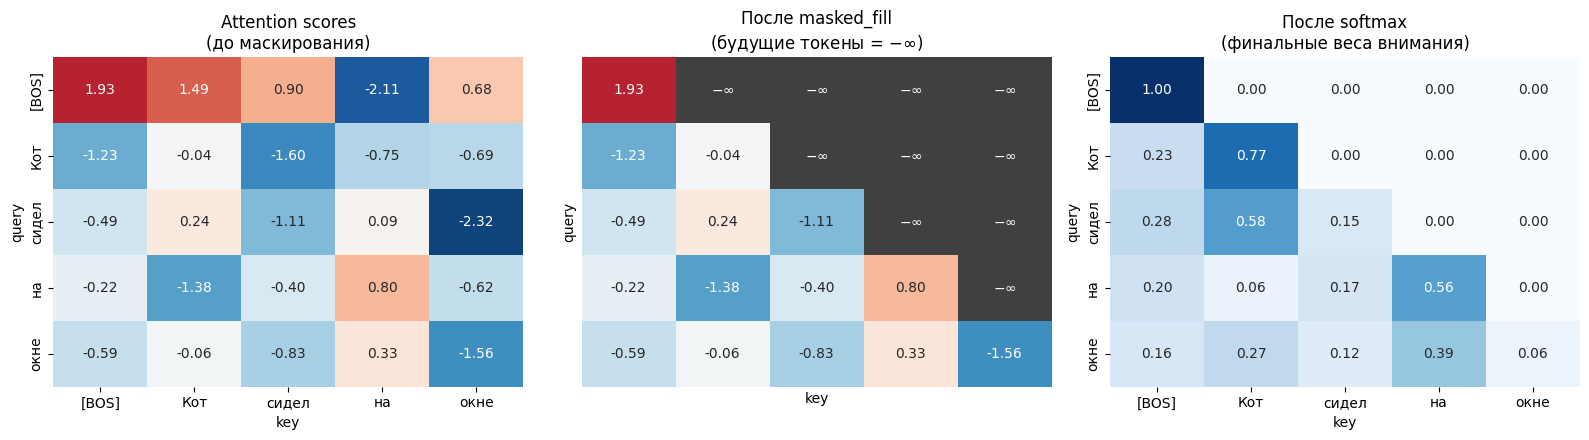

In [67]:
import matplotlib.pyplot as plt                                                                                         
import seaborn as sns                                                                
                                                                                                                      
tokens = ["[BOS]", "Кот", "сидел", "на", "окне"]                                                                        
n = len(tokens)                                                                                                         
                                                                                                                      
torch.manual_seed(42)
scores = torch.randn(n, n)
mask = torch.tril(torch.ones(n, n))
masked_scores = scores.masked_fill(mask == 0, float('-inf'))
attention_weights = F.softmax(masked_scores, dim=-1)

fig, axes = plt.subplots(1, 3, figsize=(16, 4.5))

sns.heatmap(scores.numpy(), annot=True, fmt='.2f', cmap='RdBu_r', vmin=-2.5, vmax=2.5,
          xticklabels=tokens, yticklabels=tokens, ax=axes[0], cbar=False)
axes[0].set_title('Attention scores\n(до маскирования)')

# masked_fill заменяет будущие токены на -inf, отображаем их серым
sns.heatmap(scores.numpy(), annot=True, fmt='.2f', cmap='RdBu_r', vmin=-2.5, vmax=2.5,
          xticklabels=tokens, yticklabels=tokens, ax=axes[1], cbar=False,
          mask=(mask.numpy() == 0))
sns.heatmap(mask.numpy(), cmap=['#404040'], annot=[['' if mask[i,j] else r'$-\infty$' for j in range(n)] for i in
range(n)],
          fmt='', ax=axes[1], cbar=False, xticklabels=False, yticklabels=False,
          mask=(mask.numpy() == 1), alpha=1)
axes[1].set_title('После masked_fill\n' + r'(будущие токены = $-\infty$)')

sns.heatmap(attention_weights.numpy(), annot=True, fmt='.2f', cmap='Blues', vmin=0, vmax=1,
          xticklabels=tokens, yticklabels=tokens, ax=axes[2], cbar=False)
axes[2].set_title('После softmax\n(финальные веса внимания)')

for ax in axes:
  ax.set_xlabel('key')
  ax.set_ylabel('query')

plt.tight_layout()
plt.show()

### deep learning layers torch

In [68]:
# Embedding слой сопоставляет вектор индексу
# первый аргумент - размерность словаря
# второй - размерность вектора
embed = nn.Embedding(10, 20)

In [69]:
# два текста по 4 токена в каждом
t = torch.LongTensor([[1,3,4,5], [3,4,5,6]])

In [70]:
t.shape

torch.Size([2, 4])

In [71]:
# в результате каждому токену сопоставляется вектор 20
embed(t).shape

torch.Size([2, 4, 20])

In [72]:
# полносвязный слой или линейной преобразование
# первый аргумент изначальная размерность
# второй - выходная размерность
linear = nn.Linear(2, 10)

In [73]:
# изначально у нас есть batch с двумя примерами где каждый состоит из трех токенов и у каждого токена вектор 2
t = torch.rand((2, 3, 2))

In [74]:
# применив полносвязный слой мы получим то же самое только размерность векторов теперь 10
linear(t).shape

torch.Size([2, 3, 10])

In [75]:
# функция активации которая зануляет отрицательные значения
relu = nn.ReLU()

In [76]:
linear(t), relu(linear(t))

(tensor([[[ 0.0375,  1.1470, -0.7301, -0.2236,  0.0889, -0.2165, -0.5736,
           -0.5245,  0.8718, -1.3578],
          [ 0.1089,  0.7497, -0.7071, -0.1852, -0.1881, -0.1363, -0.4466,
           -0.3905,  0.2948, -0.9997],
          [ 0.0305,  0.5101, -0.8397, -0.2467, -0.2322, -0.0714, -0.5063,
           -0.4755, -0.0355, -0.7495]],
 
         [[ 0.3961,  0.7414, -0.3623,  0.0150, -0.4834, -0.1736, -0.1232,
            0.0026,  0.2413, -1.0727],
          [ 0.1114,  0.5532, -0.7353, -0.1890, -0.2920, -0.0921, -0.4206,
           -0.3689,  0.0142, -0.8133],
          [ 0.0506,  0.7070, -0.7842, -0.2271, -0.1510, -0.1187, -0.5071,
           -0.4662,  0.2424, -0.9426]]], grad_fn=<ViewBackward0>),
 tensor([[[0.0375, 1.1470, 0.0000, 0.0000, 0.0889, 0.0000, 0.0000, 0.0000,
           0.8718, 0.0000],
          [0.1089, 0.7497, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.2948, 0.0000],
          [0.0305, 0.5101, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          

In [77]:
# softmax - функция активации которая нормализует значения в векторе так что они лежат в интервале от 0-1 и суммируются в 1
linear(t), F.softmax(linear(t), dim=-1)

(tensor([[[ 0.0375,  1.1470, -0.7301, -0.2236,  0.0889, -0.2165, -0.5736,
           -0.5245,  0.8718, -1.3578],
          [ 0.1089,  0.7497, -0.7071, -0.1852, -0.1881, -0.1363, -0.4466,
           -0.3905,  0.2948, -0.9997],
          [ 0.0305,  0.5101, -0.8397, -0.2467, -0.2322, -0.0714, -0.5063,
           -0.4755, -0.0355, -0.7495]],
 
         [[ 0.3961,  0.7414, -0.3623,  0.0150, -0.4834, -0.1736, -0.1232,
            0.0026,  0.2413, -1.0727],
          [ 0.1114,  0.5532, -0.7353, -0.1890, -0.2920, -0.0921, -0.4206,
           -0.3689,  0.0142, -0.8133],
          [ 0.0506,  0.7070, -0.7842, -0.2271, -0.1510, -0.1187, -0.5071,
           -0.4662,  0.2424, -0.9426]]], grad_fn=<ViewBackward0>),
 tensor([[[0.0929, 0.2819, 0.0431, 0.0716, 0.0978, 0.0721, 0.0504, 0.0530,
           0.2141, 0.0230],
          [0.1201, 0.2280, 0.0531, 0.0895, 0.0892, 0.0940, 0.0689, 0.0729,
           0.1446, 0.0396],
          [0.1243, 0.2008, 0.0521, 0.0942, 0.0956, 0.1122, 0.0727, 0.0749,
          

In [78]:
# LayerNorm нормализует значения в векторах так что среднее равно 0 а стандартное отклонение 1
ln = nn.LayerNorm(10)

In [79]:
out = linear(t)

In [80]:
out.mean(), out.std()

(tensor(-0.1874, grad_fn=<MeanBackward0>),
 tensor(0.4992, grad_fn=<StdBackward0>))

In [81]:
ln(out).mean(), ln(out).std()

(tensor(-7.9473e-09, grad_fn=<MeanBackward0>),
 tensor(1.0084, grad_fn=<StdBackward0>))

In [82]:
out, ln(out)

(tensor([[[ 0.0375,  1.1470, -0.7301, -0.2236,  0.0889, -0.2165, -0.5736,
           -0.5245,  0.8718, -1.3578],
          [ 0.1089,  0.7497, -0.7071, -0.1852, -0.1881, -0.1363, -0.4466,
           -0.3905,  0.2948, -0.9997],
          [ 0.0305,  0.5101, -0.8397, -0.2467, -0.2322, -0.0714, -0.5063,
           -0.4755, -0.0355, -0.7495]],
 
         [[ 0.3961,  0.7414, -0.3623,  0.0150, -0.4834, -0.1736, -0.1232,
            0.0026,  0.2413, -1.0727],
          [ 0.1114,  0.5532, -0.7353, -0.1890, -0.2920, -0.0921, -0.4206,
           -0.3689,  0.0142, -0.8133],
          [ 0.0506,  0.7070, -0.7842, -0.2271, -0.1510, -0.1187, -0.5071,
           -0.4662,  0.2424, -0.9426]]], grad_fn=<ViewBackward0>),
 tensor([[[ 0.2640,  1.8420, -0.8277, -0.1074,  0.3371, -0.0973, -0.6052,
           -0.5354,  1.4505, -1.7206],
          [ 0.6316,  1.9857, -1.0927,  0.0102,  0.0040,  0.1135, -0.5422,
           -0.4236,  1.0245, -1.7110],
          [ 0.7679,  2.0285, -1.5195,  0.0392,  0.0773,  0.5001, 

In [83]:
# dropout зануляет случайные значения в векторах
# параметр задает вероятность зануления
dropout = nn.Dropout(0.5)

In [84]:
dropout(linear(t))

tensor([[[ 0.0000,  2.2941, -1.4601, -0.4472,  0.1778, -0.4329, -0.0000,
          -0.0000,  1.7436, -0.0000],
         [ 0.0000,  1.4994, -1.4142, -0.0000, -0.3762, -0.2726, -0.0000,
          -0.0000,  0.5897, -0.0000],
         [ 0.0000,  1.0201, -1.6793, -0.0000, -0.4644, -0.0000, -1.0127,
          -0.9510, -0.0710, -0.0000]],

        [[ 0.0000,  0.0000, -0.7246,  0.0000, -0.0000, -0.3471, -0.2465,
           0.0052,  0.4825, -2.1453],
         [ 0.2229,  1.1064, -1.4706, -0.0000, -0.5839, -0.1843, -0.8412,
          -0.0000,  0.0000, -1.6266],
         [ 0.1011,  0.0000, -1.5685, -0.4542, -0.3020, -0.2373, -1.0141,
          -0.9325,  0.4849, -1.8852]]], grad_fn=<MulBackward0>)

In [85]:
# Sequential позволяет соединить несколько слоев в одно последовательное преобразование
net = nn.Sequential(
            nn.Linear(2, 10),
            nn.ReLU(),
            nn.Linear(10, 2),
            nn.Dropout(0.5),
        )

In [86]:
out = net(t)

In [87]:
out.shape

torch.Size([2, 3, 2])

In [88]:
out

tensor([[[0.3101, 1.0707],
         [0.0000, 0.9353],
         [0.0000, 0.7914]],

        [[0.0000, 0.8822],
         [0.6820, 0.0000],
         [0.5924, 0.9134]]], grad_fn=<MulBackward0>)

## GPT

Теперь давайте разберем код Karpathy в котором он собирает GPT и обучим ее на наших данных.


GPT это трансформерная модель. Она реализована также как это описано в статье Attention is all you need, за исключением того, что в GPT есть только decoder (правый столб). Статья AIAYN изначально про машинный перевод и поэтому в ней используется encoder-decoder архитектура. 
Декодером GPT делает то, что в ней используется causal attention, где каждый токен общается только с предыдущими. В encoder все токены взаимодействуют со всеми.
Также небольшое отличие состоит в порядке применения layerNorm (сейчас его перенесли до MHA и до FF)



![](https://substackcdn.com/image/fetch/f_auto,q_auto:good,fl_progressive:steep/https%3A%2F%2Fbucketeer-e05bbc84-baa3-437e-9518-adb32be77984.s3.amazonaws.com%2Fpublic%2Fimages%2F0235fd2f-26f4-47ff-b95e-eddf6a4593b0_782x1152.png)

In [89]:
64/4

16.0

In [90]:
# hyperparameters
block_size = MAX_LEN # what is the maximum context length for predictions?
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_embd = 64 # размерность эмбеддингов и векторов внутри трансформера
#ffn_hid_dim = n_embd * 4
n_head = 4
n_layer = 4
dropout = 0.0

In [91]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        if mask is not None:
            wei = wei.masked_fill(~mask.unsqueeze(1), float('-inf'))
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        out = torch.cat([h(x, mask) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, inp):
        x, mask = inp
        x = x + self.sa(self.ln1(x), mask)
        x = x + self.ffwd(self.ln2(x))
        return (x, mask)

In [92]:
class GPTLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None, mask=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x, mask = self.blocks((x, mask)) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets, ignore_index=PAD_IDX)

        return logits, loss

    def generate(self, idx, max_new_tokens, stop_token):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)# (B, 1)
            if idx_next == stop_token:
                break
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

In [93]:
model = GPTLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

4.073392 M parameters


In [94]:
# model

In [95]:
# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

Код обучения просто передает в модель батчи из датасета

In [96]:
def train(model, iterator, optimizer, print_every=10):
    epoch_loss = []
    model.train()  

    for i, (xs, ys, mask) in enumerate(iterator):
        optimizer.zero_grad()   
        logits, loss = model(xs.to(device), ys.to(device), mask.to(device)) 
        
        loss.backward()
        optimizer.step()
        
        epoch_loss.append(loss.item())
        
        if not (i+1) % print_every:
            print(f'Loss: {torch.Tensor(epoch_loss).mean(-1)}')
        
    return torch.Tensor(epoch_loss).mean(-1)

def evaluate(model, iterator):
    epoch_loss = []
    model.eval()  
    with torch.no_grad():
        for xs, ys, mask in iterator:   
            logits, loss = model(xs.to(device), ys.to(device), mask.to(device))     
            epoch_loss.append(loss.item())  
            
    return torch.Tensor(epoch_loss).mean(-1)

При обучении после каждой эпохи генерируется текст чтобы видеть прогресс

In [97]:
train_losses = []
eval_losses = []
for i in range(30):
    print(i)
    train_losses.append(train(model, training_generator, optimizer, 100))
    eval_loss = evaluate(model, val_generator)
    print('Eval - ', eval_loss.item())
    eval_losses.append(eval_loss)
    for _ in range(3):
        pred = model.generate(torch.LongTensor([[tokenizer.token_to_id('[BOS]')]]).to(device), 200, tokenizer.token_to_id('[EOS]'))
        print(tokenizer.decoder.decode([tokenizer.id_to_token(i) for i in pred.detach().cpu().numpy()[0]][1:-1]))

0
Loss: 8.545097351074219
Loss: 8.1570405960083
Loss: 7.965719223022461
Loss: 7.8256378173828125
Loss: 7.714413166046143
Loss: 7.6127214431762695
Loss: 7.521690368652344
Loss: 7.434639930725098
Loss: 7.352936267852783
Loss: 7.275872707366943
Loss: 7.203457832336426
Loss: 7.137126445770264
Loss: 7.07350492477417
Loss: 7.014610290527344
Loss: 6.959110736846924
Loss: 6.907113075256348
Loss: 6.8565354347229
Loss: 6.809677600860596
Loss: 6.764639377593994
Loss: 6.722314357757568
Loss: 6.681594371795654
Loss: 6.643990993499756
Eval -  5.834073543548584
Жело возможности обнаружены коллегам состав к отканиванием
Общая дипломат взрывов около 800 человек Ларпетита прославиются на 7 миллионов рублей
Она создали название вывол редером и астроногачистки криметч
1
Loss: 5.754202842712402
Loss: 5.7365946769714355
Loss: 5.71923828125
Loss: 5.70347785949707
Loss: 5.689840793609619
Loss: 5.676103591918945
Loss: 5.66335916519165
Loss: 5.648715972900391
Loss: 5.636997222900391
Loss: 5.625178337097168
Loss